In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torcheval.metrics import MulticlassAccuracy
from torchinfo import summary

In [2]:
# gettign the data
train_data = datasets.FashionMNIST(
    root= "data",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_data = datasets.FashionMNIST(
    root= "data",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)


In [3]:
device = "cuda"

In [4]:
class_names = train_data.classes

In [5]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
image, label = train_data[0]

Text(0.5, 1.0, 'Ankle boot')

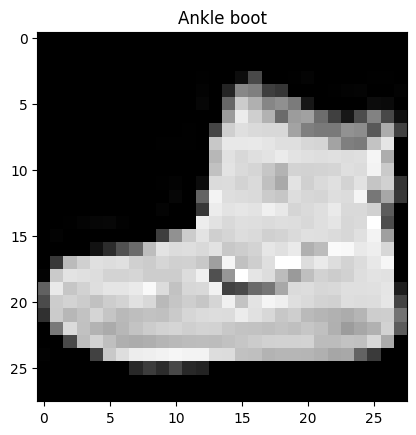

In [7]:
plt.imshow(image.squeeze(), cmap="gray" )
plt.title(class_names[label])

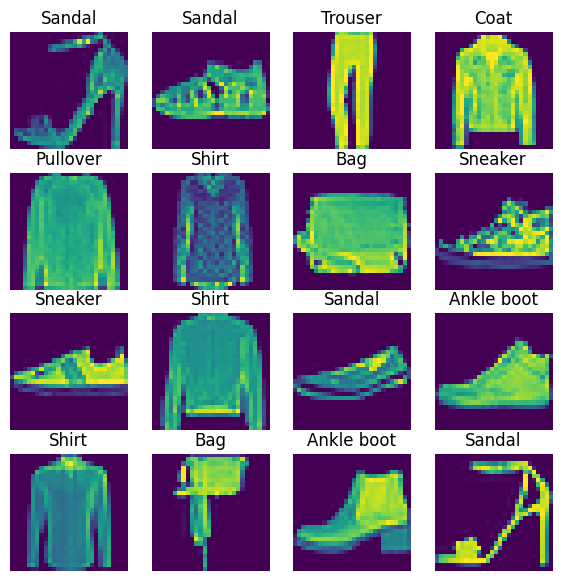

In [8]:
rows, cols = 4,4
fig = plt.figure(figsize=(7,7))
for i in range(1, rows*cols +1):
    random = int(torch.randint(1, len(train_data), size=[1]).item())
    img, la = train_data[random]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze())
    plt.title(class_names[la])
    plt.axis(False)

In [67]:
class ImageClassifier(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            nn.Conv2d(1,32,(3,3), padding=1), # 28*28
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(32,64,(3,3)), # 26 x 26
            nn.MaxPool2d(2,1), # 25 x 25
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(64,64,(3,3)), # 23 x 23
            nn.MaxPool2d(2,1), # 22 x 22
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Conv2d(64,32,(3,3)), # 20 x 2
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*(20)*(20),10),
        )

    def forward(self, x):
        return self.layers(x)

In [68]:
model = ImageClassifier().to(device)

In [69]:
summary(model=model)

Layer (type:depth-idx)                   Param #
ImageClassifier                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Conv2d: 2-4                       18,496
│    └─MaxPool2d: 2-5                    --
│    └─ReLU: 2-6                         --
│    └─Dropout: 2-7                      --
│    └─Conv2d: 2-8                       36,928
│    └─MaxPool2d: 2-9                    --
│    └─ReLU: 2-10                        --
│    └─Dropout: 2-11                     --
│    └─Conv2d: 2-12                      18,464
│    └─ReLU: 2-13                        --
│    └─Flatten: 2-14                     --
│    └─Linear: 2-15                      128,010
Total params: 202,218
Trainable params: 202,218
Non-trainable params: 0

In [70]:
train_data_ldr = DataLoader(train_data, batch_size=32, shuffle=True)
test_data_ldr = DataLoader(test_data, batch_size=32, shuffle=True)

In [71]:
for img, label in train_data_ldr:
    with torch.inference_mode():
        preds = model(img.to(device))
    break

In [72]:
with torch.inference_mode():
    preds = model(img.to(device))

preds.shape

torch.Size([32, 10])

In [79]:
optimizer = optim.Adam(model.parameters(), lr = 2e-3, weight_decay=0.02)
loss_fn = nn.CrossEntropyLoss()
epochs = 10
accuracy_fn = MulticlassAccuracy()
total_train_length = len(train_data_ldr)
total_test_length = len(test_data_ldr)


In [80]:
import time
history = {}
history["test_loss"] = []
history["train_loss"] = []
history["train_accuracy"] = []
history["test_accuracy"] = []

In [81]:
for epoch in range(epochs):
    total_train_acc = 0
    total_test_acc = 0
    start = time.time()
    train_loss = 0
    test_loss_total = 0
    model.train()
    for batch in train_data_ldr:
        img, label = batch
        img,label = img.to(device), label.to(device).long()
        
        y_logits= model(img)
        # print(y_logits)
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
        # print(y_preds)

        loss = loss_fn(y_logits, label)
        train_loss += loss

        acc = accuracy_fn.update(y_preds, label).compute()

        total_train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    for batch in test_data_ldr:
        test_img, test_label = batch
        test_img,  test_label = test_img.to(device), test_label.to(device).long()
        
        with torch.inference_mode():
            test_y_logits= model(test_img)
            test_y_preds = torch.softmax(test_y_logits, dim=1).argmax(dim=1)
            test_loss = loss_fn(test_y_logits, test_label)
            test_loss_total += test_loss
            test_acc = accuracy_fn.update(test_y_preds, test_label).compute()

            total_test_acc += test_acc
    with torch.inference_mode():
        history["train_loss"].append((train_loss / total_train_length))
        history["test_loss"].append(test_loss_total / total_test_length)
    history["test_accuracy"].append(total_test_acc/total_test_length)
    history["train_accuracy"].append(total_train_acc/total_train_length)
    
    
    end = time.time()
    print(f"Took: {end-start} for epoch : {epoch+1}: ")
    print(f"Train Loss is: {train_loss / total_train_length} \t\t | Test Loss is: {test_loss_total/ total_test_length}")
    print(f"Train Accuracy is: {total_train_acc/total_train_length} \t\t | Test Accuracy : {total_test_acc/total_test_length}")
    print("-"*40)
    print()

Took: 16.1429226398468 for epoch : 1: 
Train Loss is: 0.4703294336795807 		 | Test Loss is: 0.5384308695793152
Train Accuracy is: 0.8465929627418518 		 | Test Accuracy : 0.8307502865791321
----------------------------------------



KeyboardInterrupt: 

Predicited Class : Dress 
Actual Class: Dress


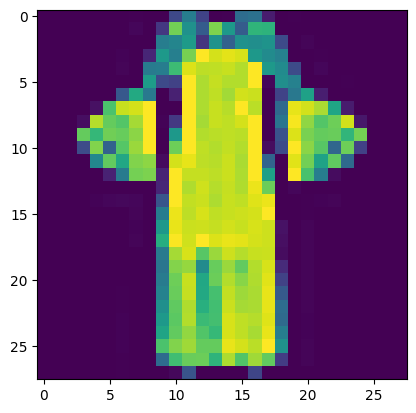

In [ ]:
random = int(torch.randint(1, len(train_data), size=[1]).item())
img, label = train_data[random]
image = torch.unsqueeze(img, 1)
# print(image.shape)
plt.imshow(img.squeeze())
logit = model(image.to(device))
pred = torch.softmax(logit,1).argmax().item()
print(f"Predicited Class : {class_names[pred]} \nActual Class: {class_names[label]}")

In [30]:
torch.save(model, "mutliclass.h")

In [76]:
history["train_loss"] = [x.to("cpu") for x in history["train_loss"]]
history["test_loss"] = [x.to("cpu") for x in history["test_loss"]]

[]

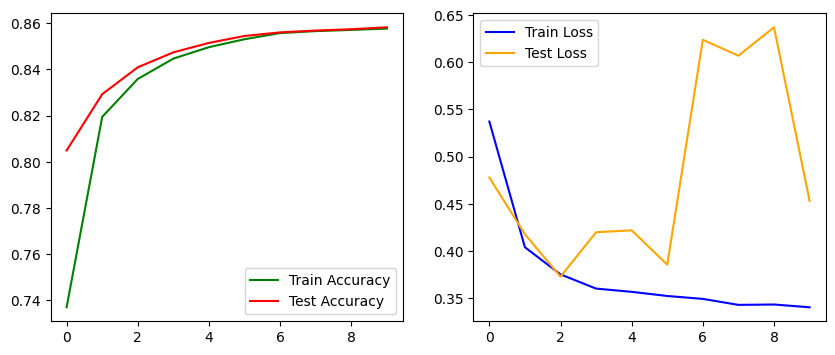

In [78]:
# visualizing the training and testing metrics overepochs
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_accuracy"], label="Train Accuracy", c = "g")
plt.plot(history["test_accuracy"], label = "Test Accuracy", c= "r")
plt.legend()
plt.plot()
plt.subplot(1,2,2)
plt.plot(history["train_loss"], label="Train Loss", c = "b")
plt.plot(history["test_loss"], label = "Test Loss", c ="orange")
plt.legend()
plt.plot()